In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

import scipy.cluster.hierarchy as hac

import math

import random

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from fbprophet import Prophet

import random


# References

In [2]:
# https://alpynepyano.github.io/healthyNumerics/posts/time_series_clustering_with_python.html
# https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/
# https://dius.com.au/2018/09/04/time-series-forecasting-with-fbprophet/
# https://www.kaggle.com/beebopjones/bleepblop-prophet-model
# https://www.kaggle.com/viridisquotient/sarima

# Gain an understanding of data features

In [3]:
df = pd.read_csv("../input/demand-forecasting-kernels-only/train.csv")
print(df.head(10))

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
5  2013-01-06      1     1     12
6  2013-01-07      1     1     10
7  2013-01-08      1     1      9
8  2013-01-09      1     1     12
9  2013-01-10      1     1      9


In [4]:
# Find unique columns
print("length of database",len(df))
print("Unique Stores",df['store'].unique())
print("Unique items",df['item'].unique())
print("Unique dates",df['date'].nunique())



length of database 913000
Unique Stores [ 1  2  3  4  5  6  7  8  9 10]
Unique items [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Unique dates 1826


In [5]:
# Include holidays
holidays = pd.read_csv("../input/federal-holidays-usa-19662020/usholidays.csv")


holidays = holidays.drop(columns=["Unnamed: 0"])
print(holidays.head(10))


         Date                              Holiday
0  2010-12-31                       New Year's Day
1  2011-01-17  Birthday of Martin Luther King, Jr.
2  2011-02-21                Washington's Birthday
3  2011-05-30                         Memorial Day
4  2011-07-04                     Independence Day
5  2011-09-05                            Labor Day
6  2011-10-10                         Columbus Day
7  2011-11-11                         Veterans Day
8  2011-11-24                     Thanksgiving Day
9  2011-12-26                        Christmas Day


In [6]:
df['date'] = pd.to_datetime(df['date']) 
holidays['Date'] = pd.to_datetime(holidays['Date']) 
needed_holidays = holidays[(holidays['Date']>df.iloc[0]['date'])&(holidays['Date']<df.iloc[-1]['date'])]['Date'].to_list()
print(len(needed_holidays))

# For later Analysis
holidays = holidays[(holidays['Date']>df.iloc[0]['date'])&(holidays['Date']<df.iloc[-1]['date'])]
holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True)

49


In [7]:
select_values = needed_holidays
df_cut = df[df['date'].isin(select_values)]['date']
print(df_cut.nunique())

# Holidays have been included

49


In [8]:
# Check for Missing  data
total = df.isnull().sum()
print(total)

date     0
store    0
item     0
sales    0
dtype: int64


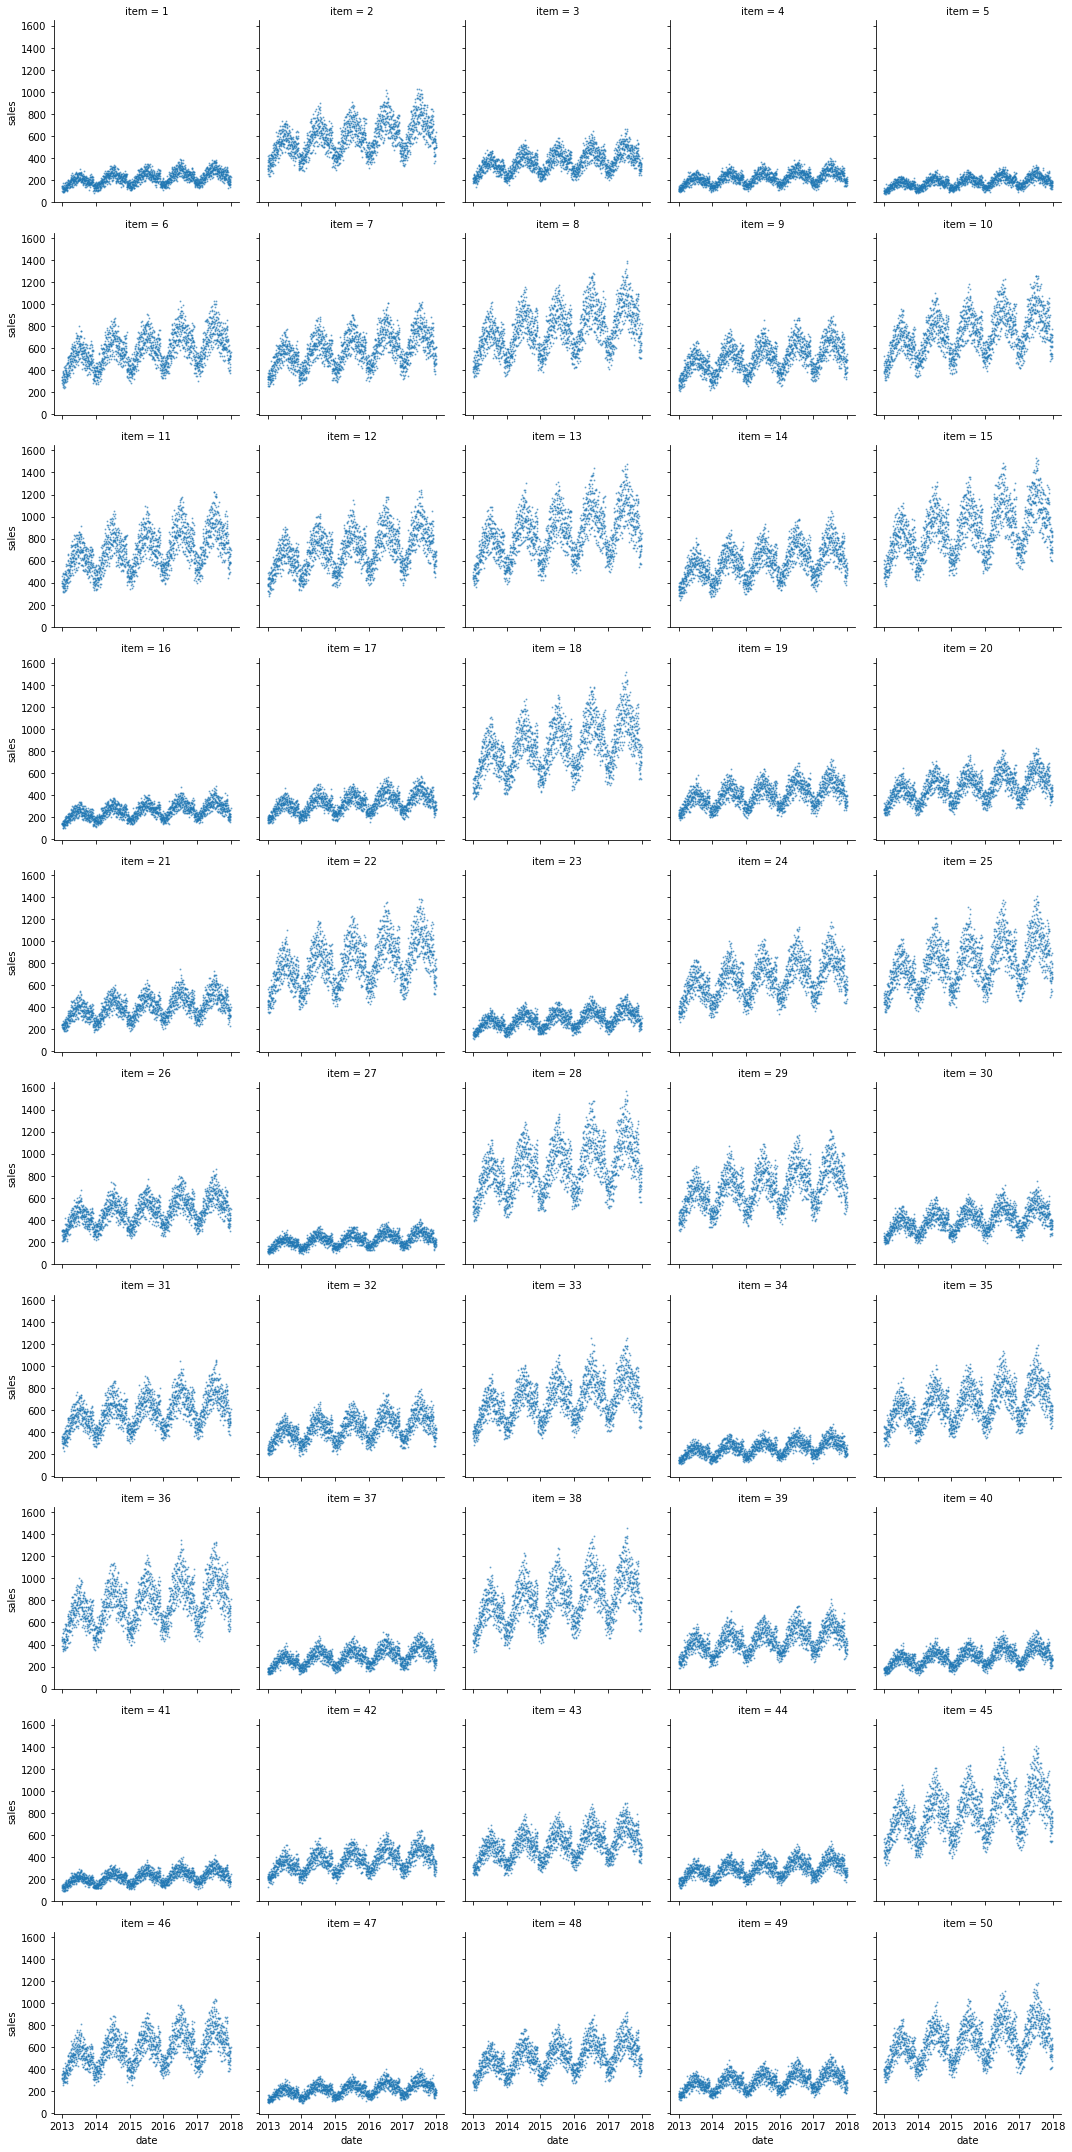

In [9]:
# Getting individual distributions of sales for each item. Taking sum to summate sales for different stores
df['date'] = pd.to_datetime(df['date']) 

df_sales_item = df.groupby(['date','item']).sum()  
df_sales_item.reset_index(level=0, inplace=True)
df_sales_item.reset_index(level=0, inplace=True)
#print(df_sales_item)

grid = sns.FacetGrid(df_sales_item, col="item", col_wrap=5)
grid = grid.map(plt.scatter, "date", "sales", marker="o", s=1, alpha=.5)

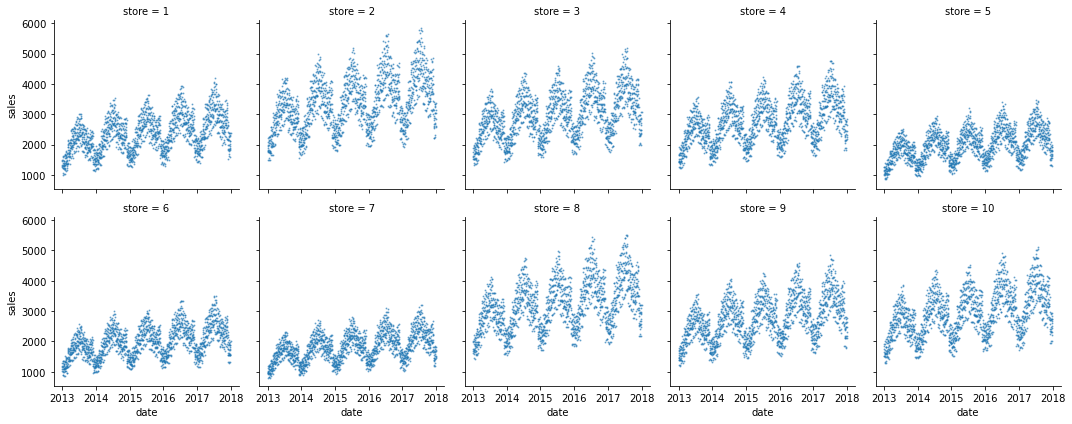

In [10]:
# Getting individual distributions of sales for each store. Taking sum to summate sales for different items
df['date'] = pd.to_datetime(df['date']) 

df_sales_store = df.groupby(['date','store']).sum()  
df_sales_store.reset_index(level=0, inplace=True)
df_sales_store.reset_index(level=0, inplace=True)


grid = sns.FacetGrid(df_sales_store, col="store", col_wrap=5)
gris = grid.map(plt.scatter, "date", "sales", s=1, alpha=.5)

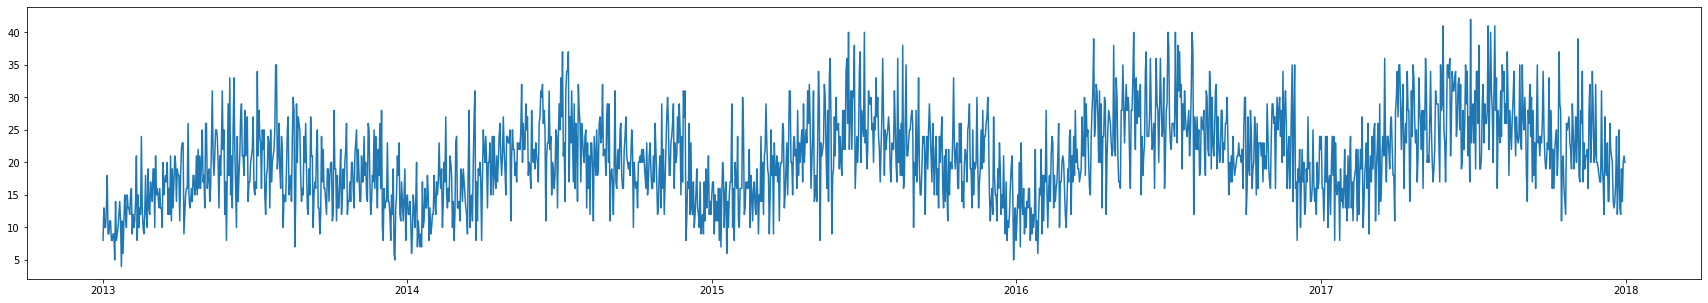

In [11]:
# Lets look at sales for a specified store and a item
plt.figure(figsize=(30,5))
df_store_item = df[(df.store==10) & (df.item==5)]
plt.plot(df_store_item['date'],df_store_item['sales'])
plt.show()

- The graphs of each combination will be different. Let's look we can cluster graphs with similar patterns

# Perform Data Clustering
This will help us understand about the variation among different groups of data and also decide in choosing the machine learning approach

In [12]:
stores = df['store'].unique()
items = df['item'].unique()

Sales_series = []
count = 0
IndexSale_Series = []
Dates = []

#df['date'] = pd.to_datetime(df['date']) 

for store in stores:
    for item in items:
        Sales = df[(df.store==store) & (df.item==item)]['sales'].to_list()
        dates = df[(df.store==store) & (df.item==item)]['date'].to_list()
        
        Dates.append(dates)
        Sales_series.append(Sales)
        
        index = [count,item,store]
        IndexSale_Series.append(index)
        
        count +=1

print("Total Elements: ",count)

Total Elements:  500


In [13]:
def plot_dendogram(Z):
    with plt.style.context('fivethirtyeight' ): 
         plt.figure(figsize=(100, 40))
         plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
         plt.xlabel('sample index', fontsize=25, fontweight='bold')
         plt.ylabel('distance', fontsize=25, fontweight='bold')
         hac.dendrogram( Z, leaf_rotation=90.,    # rotates the x axis labels
                            leaf_font_size=15., ) # font size for the x axis labels
         plt.show()
        
def plot_resultsAndReturnClusters(timeSeries, D, cut_off_level):
    result = pd.Series(hac.fcluster(D, cut_off_level, criterion='maxclust'))
    clusters = result.unique()       
    figX = 100; figY = 20
    fig = plt.subplots(figsize=(figX, figY))   
    mimg = math.ceil(cut_off_level/2.0)
    gs = gridspec.GridSpec(mimg,2, width_ratios=[1,1])
    cluster = []
    for ipic, c in enumerate(clusters):
        cluster_index = result[result==c].index
        cluster.append(cluster_index)
        
        print(ipic, "Cluster number %d has %d elements" % (c, len(cluster_index)))
        ax1 = plt.subplot(gs[ipic])
        timeSeries = np.array(timeSeries)
        ax1.plot(timeSeries.T[:,cluster_index])
        ax1.set_title(('Cluster number '+str(c)), fontsize=15, fontweight='bold')      
    
    plt.show()
    return cluster

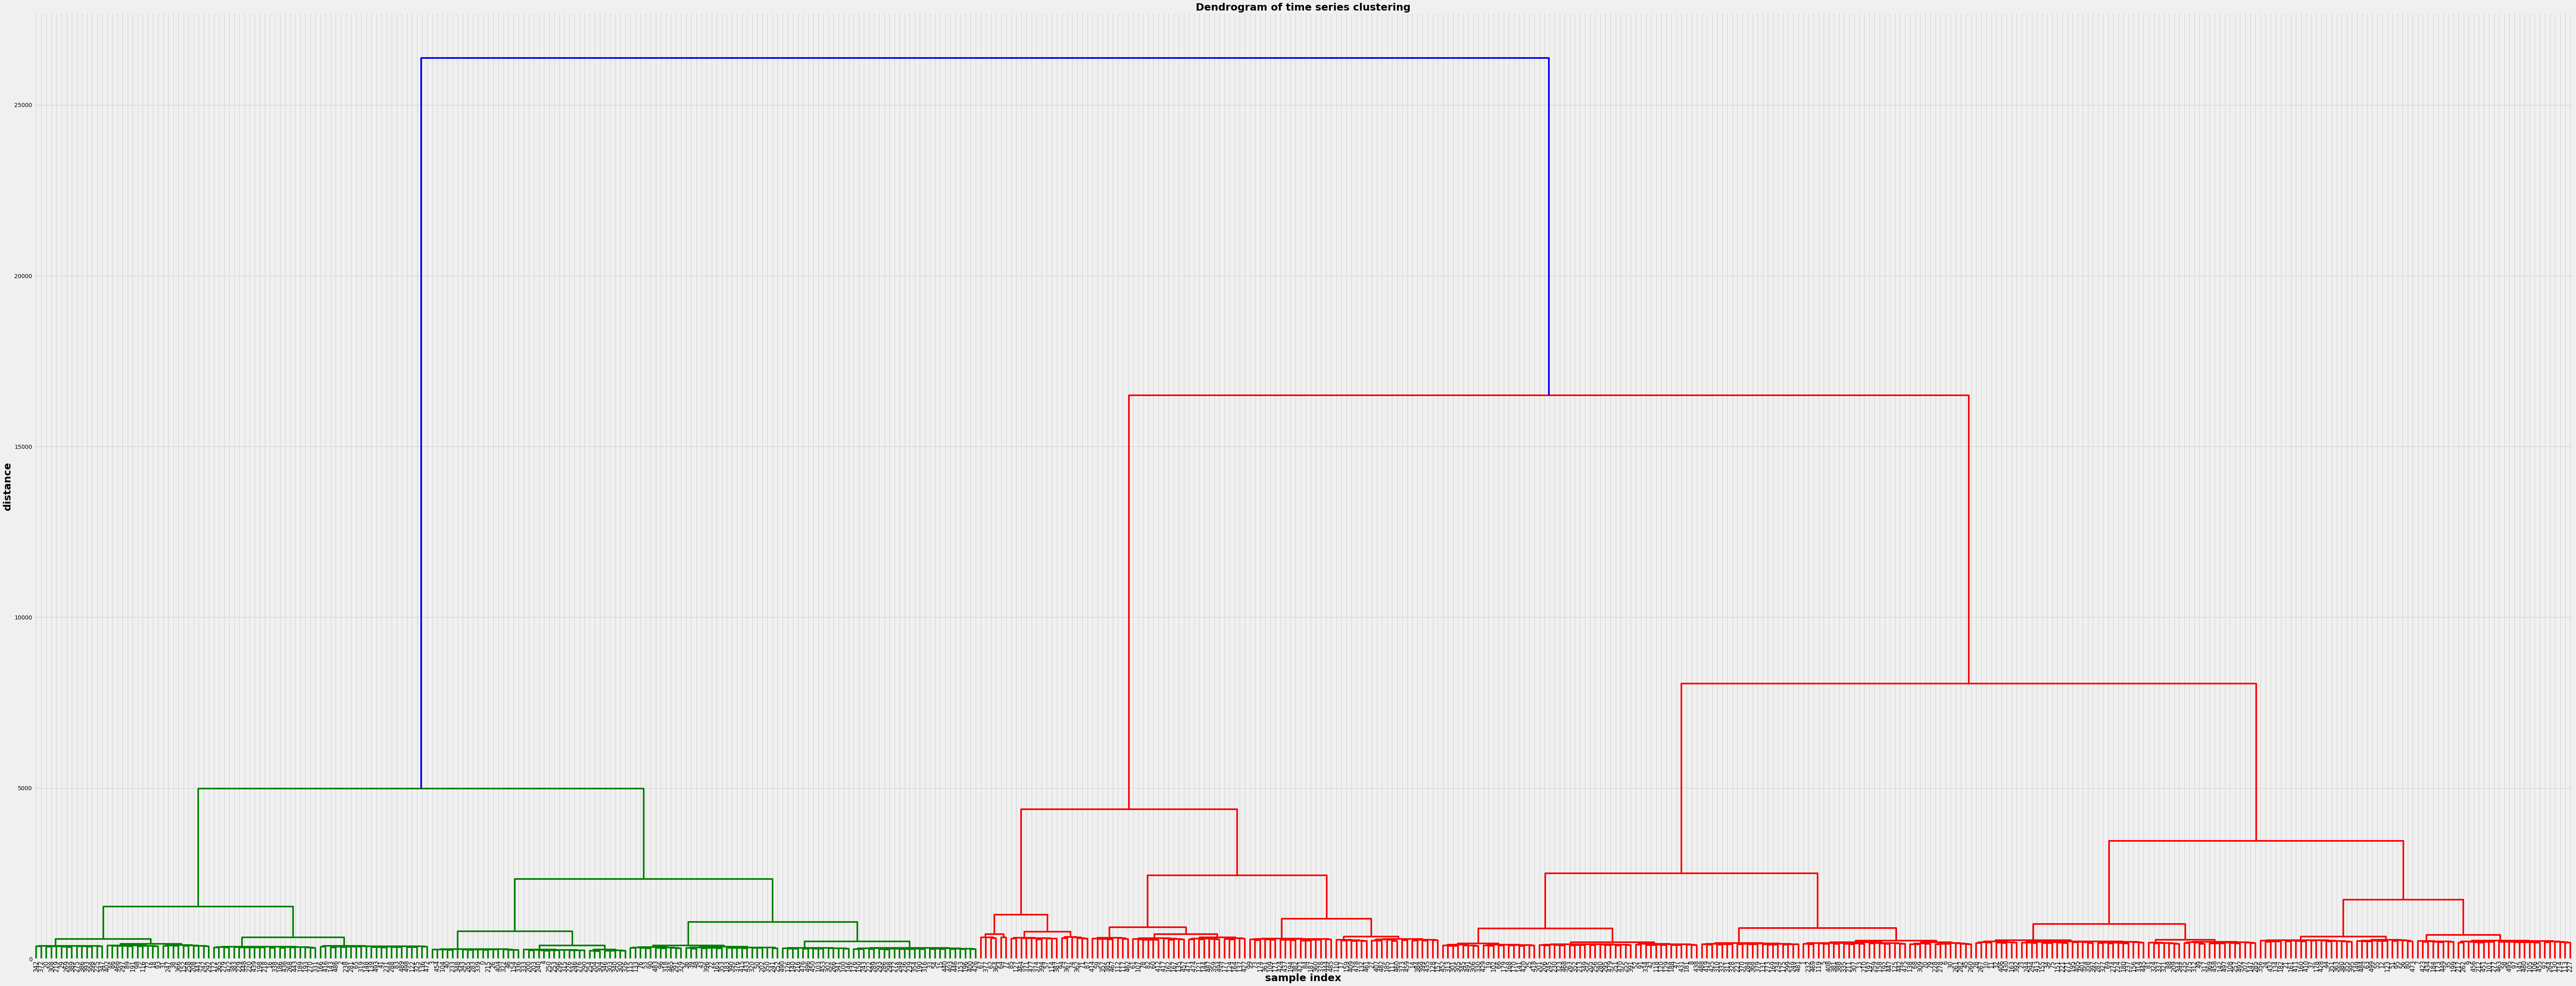

0 Cluster number 1 has 186 elements
1 Cluster number 2 has 314 elements


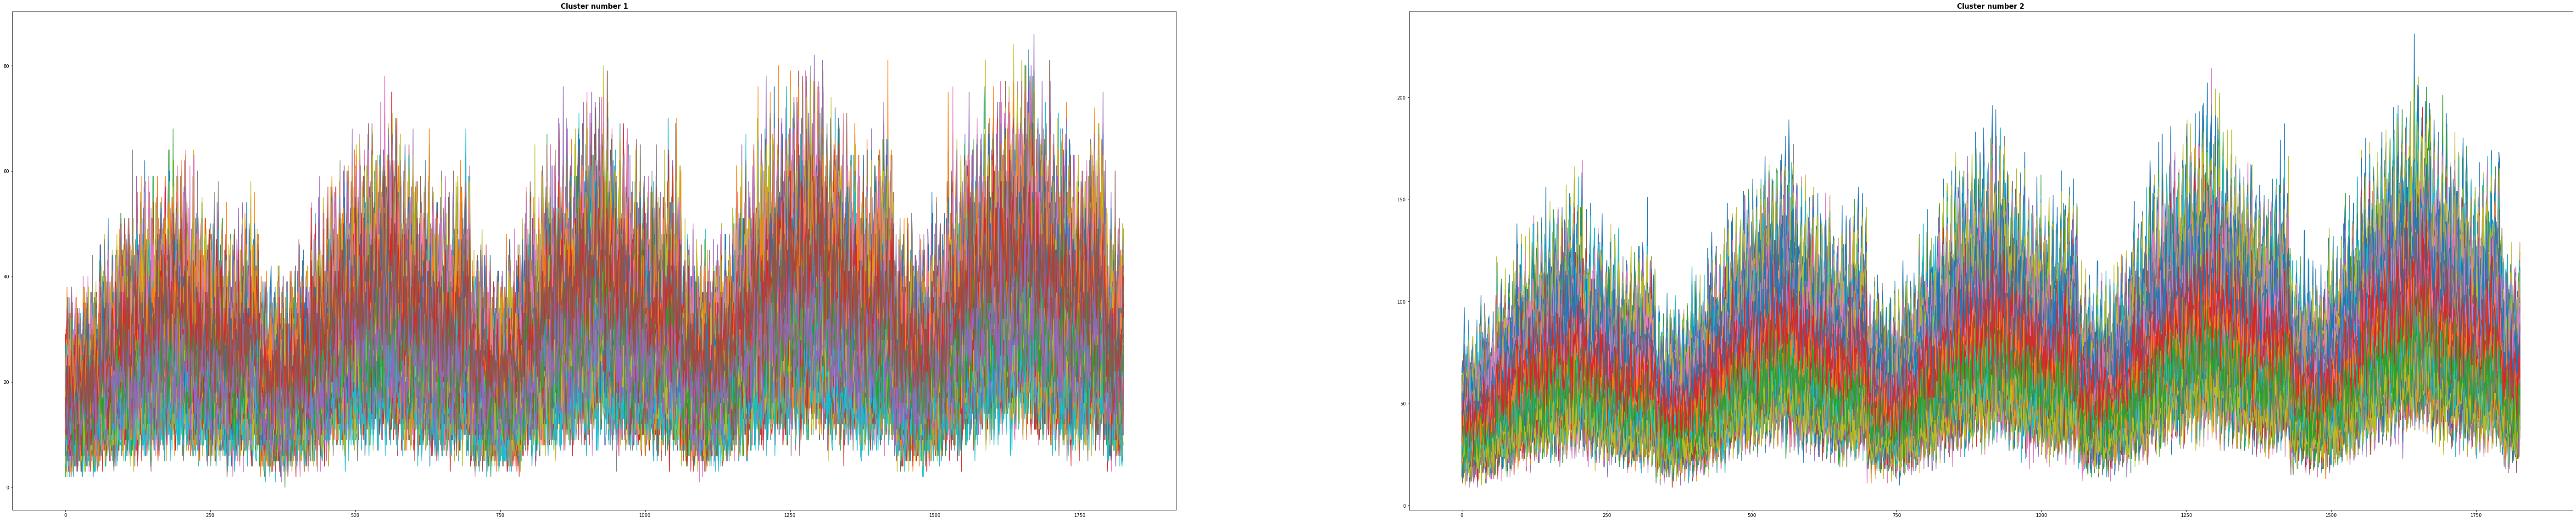

In [14]:
D = hac.linkage(Sales_series, method='ward', metric='euclidean')
plot_dendogram(D)

#---- evaluate the dendogram
cut_off_level = 2   # level where to cut off the dendogram
clusters = plot_resultsAndReturnClusters(Sales_series, D, cut_off_level)


- From the data clusters and the pentagram, we can conclude that the there is a variation of data in the time series among different stores and items

- First Cluster

In [15]:
# Random time series in cluster 1
no = random.randint(0,101)

index = clusters[0][no]

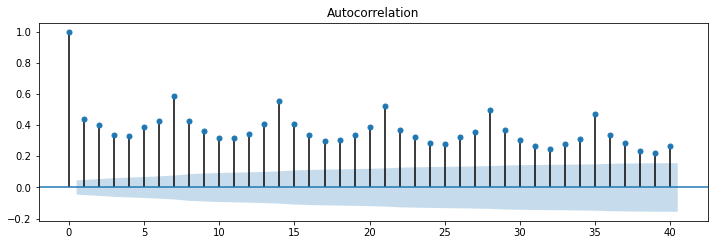

In [16]:
# Check for weekly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[index],lags=40,ax=ax)



- As we can see, there is a pattern of weekly seasonality in the data. This will be helpfull while modelling in FbProphet

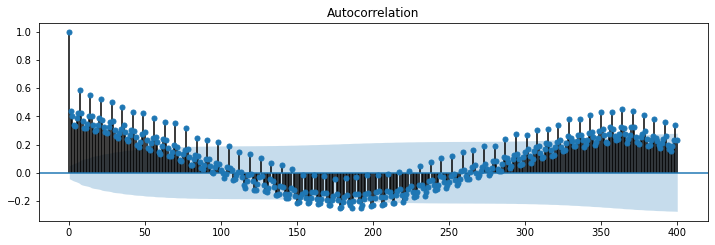

In [17]:
# Check for monthly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[index],lags=400,ax=ax)

There is a dip in sales in the middle of year, followed by a rebound in the end of the year. So rather the trend seems to follow similar patterns year on year

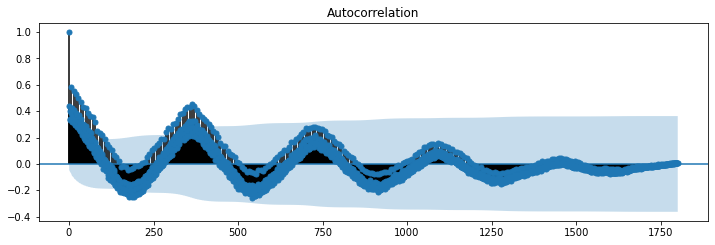

In [18]:
# Check for yearly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[index],lags=1800,ax=ax)

- A pattern of yearly seasonality but a decreasing but still significant one. 

Image Corresponding to Item: 34 And Store: 1


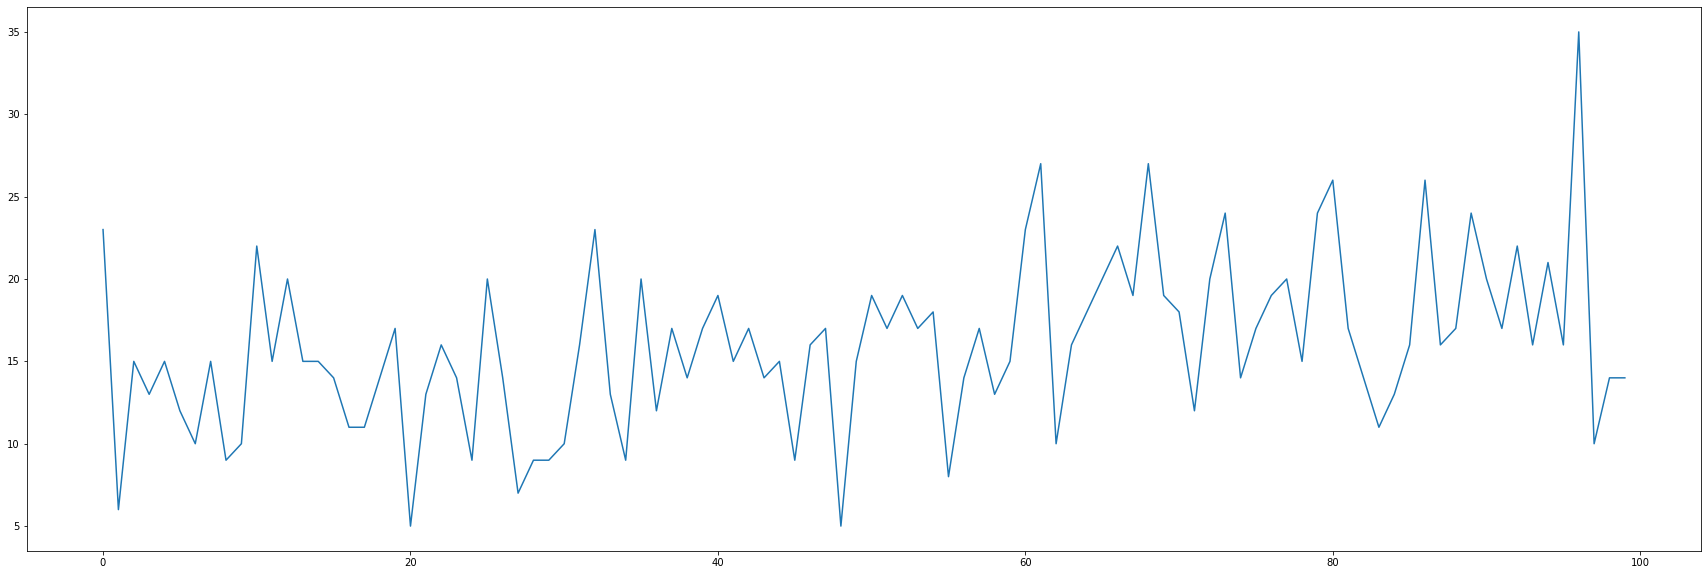

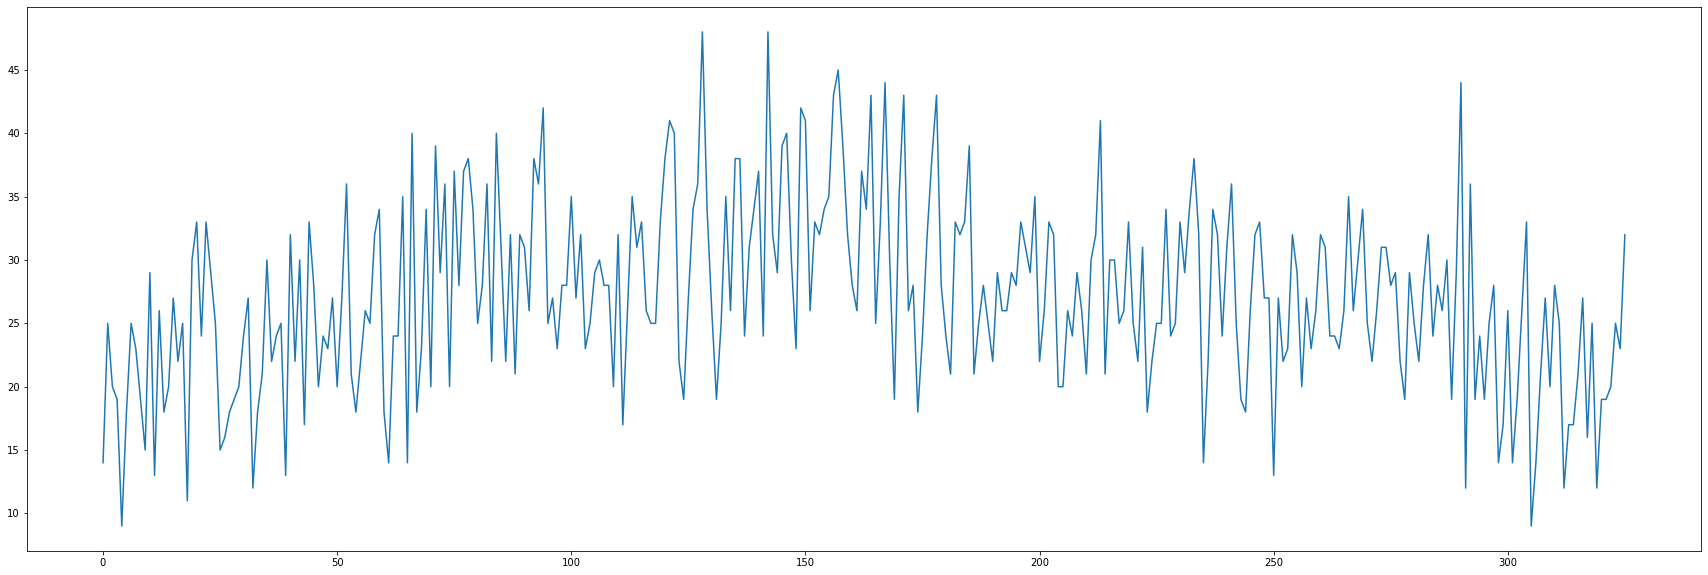

In [19]:
plt.figure(figsize=(30,10))
print("Image Corresponding to Item:",IndexSale_Series[index][1],"And Store:",IndexSale_Series[index][2])
plt.plot(Sales_series[index][:100])
plt.show()
plt.figure(figsize=(30,10))
plt.plot(Sales_series[index][1500:])
plt.show()

- The variance seems to be constant throughout, so we can use an additive model.

- From the above, data looks very seasonal after every passing year. Hence Data is non stationary. Let's see what the Dicky Fuller Test says

In [20]:
NonStationary = []

for saleID in clusters[0]:
    #print(Sales_series[saleID])
    result = adfuller(Sales_series[saleID])
    
    if result[1] > 0.05:
        
        NonStationary.append(saleID)
    else:
        pass      

print(NonStationary)


[39, 100, 133, 139, 146, 166, 193, 198, 208, 219, 231, 236, 275, 288, 296, 325, 341, 365, 372, 376, 402, 448, 496]


- Dicky Fuller Test detecting detecting non stationary behaviour only in some of the graphs. However, we know that is not the case as there is a clear seasonality in the data

# Forecast with FbProphet for a single time series. 



In [21]:
SalesSample = pd.DataFrame()
SalesSample['y'] = Sales_series[index]
SalesSample['ds'] = Dates[index]

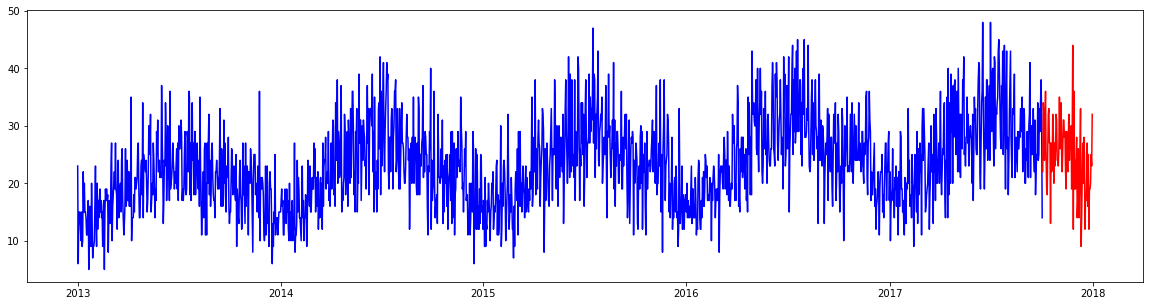

In [22]:
test_size = 90 # 3 months of data

train = SalesSample[:-test_size]
test = SalesSample[-test_size:]

plt.subplots(figsize=(20, 5))

plt.plot(train['ds'], train['y'],color='blue', label='Train')
plt.plot(test['ds'], test['y'], color='red', label='Test')


In [23]:
model = Prophet(daily_seasonality=False,
weekly_seasonality=True,
yearly_seasonality=True,
holidays = holidays, seasonality_mode='additive',holidays_prior_scale=0.5,)

# holiday prior scale to bring down the effect of holidays in the model

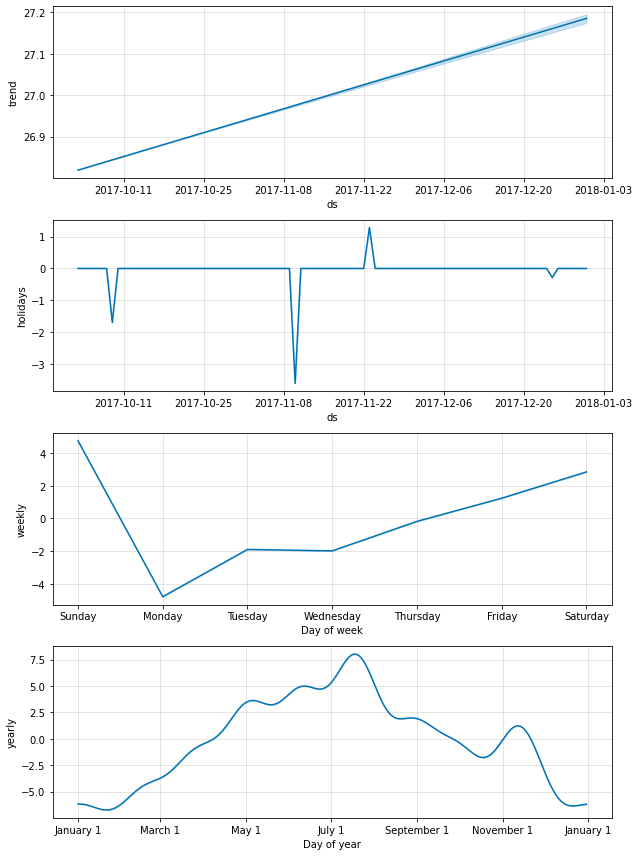

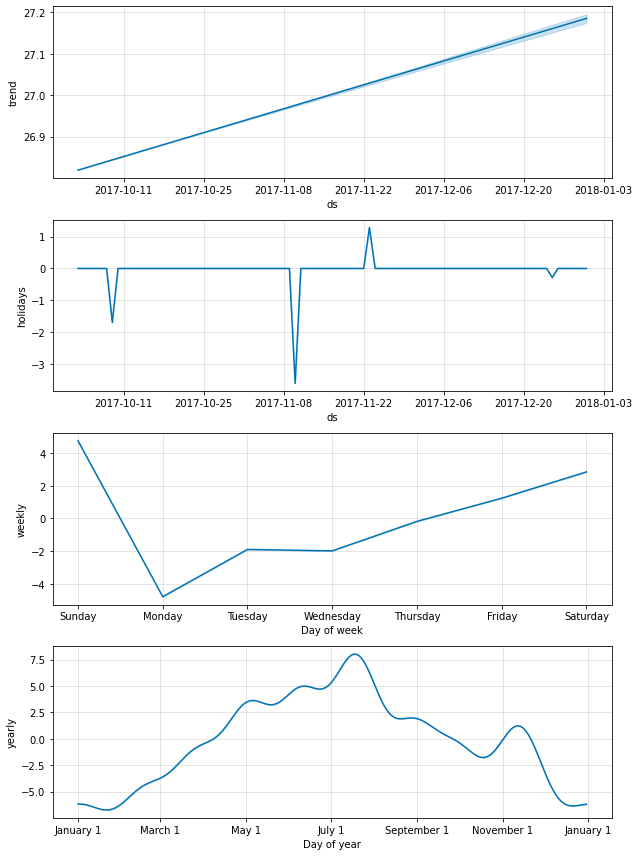

In [24]:
model.fit(train)
forecast = model.predict(test)
model.plot_components(forecast)

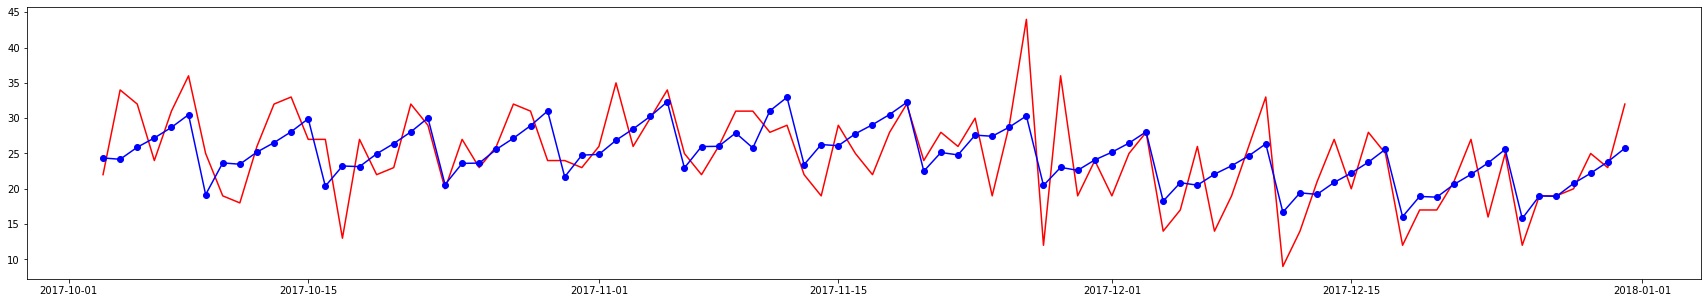

In [25]:
plt.figure(figsize=(30, 5))

plt.plot(test['ds'], test['y'], c='r', label='Test')
plt.plot(forecast['ds'], forecast['yhat'], c='blue', marker='o',label='Forecast')
plt.show()

In [26]:
# Calculate SMAPE
y_true = test['y'].to_list()
y_true = np.array(y_true)
y_forecast = forecast['yhat'].to_list()
y_forecast = np.array(y_forecast)

smape = (np.absolute(y_true - y_forecast) / (np.absolute(y_true) + np.absolute(y_forecast))).mean() * 200
print('SMAPE is:', smape)

SMAPE is: 15.846369556824206


- Lets try with applying Log Transform on the data and check for SMAPE. It will stabilse variances in the time series

In [27]:
train['y'] = np.log1p(train['y'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


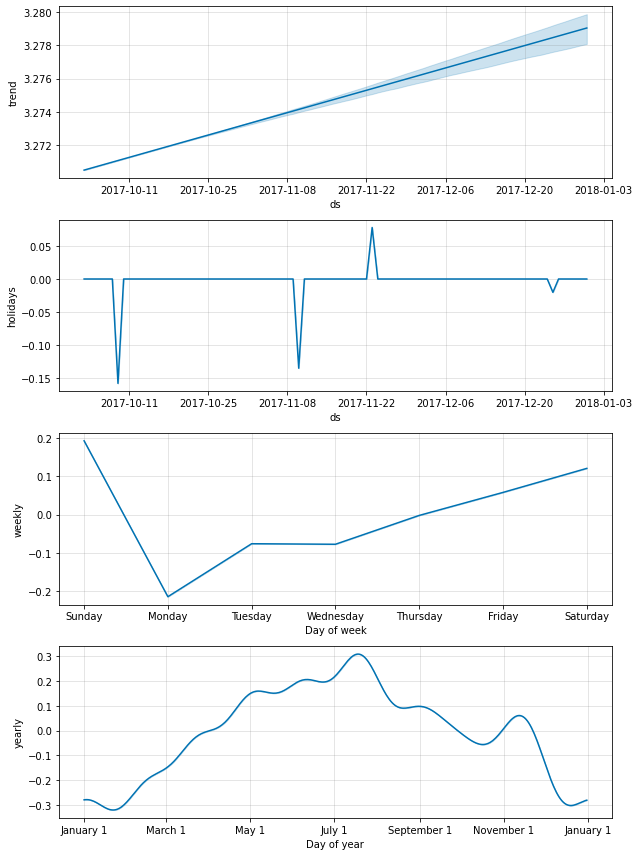

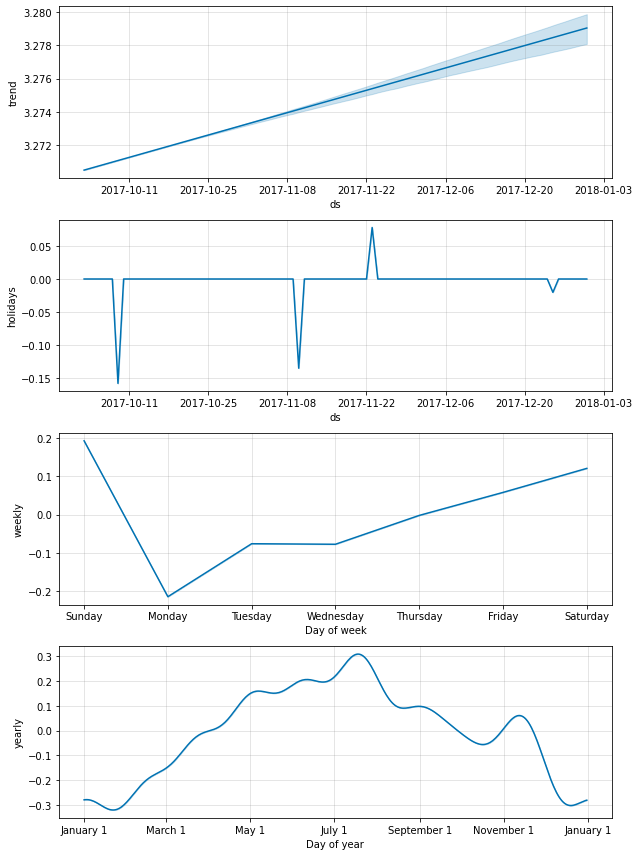

In [28]:
model = Prophet(daily_seasonality=False,
weekly_seasonality=True,
yearly_seasonality=True,
holidays = holidays, seasonality_mode='additive',holidays_prior_scale=0.5,)

model.fit(train)
forecast = model.predict(test)
model.plot_components(forecast)

In [29]:
forecast['yhat'] = np.expm1(forecast['yhat'])
print(forecast['yhat'])

0     22.916023
1     22.786692
2     24.549619
3     26.031217
4     27.679647
        ...    
85    17.399352
86    18.890213
87    20.172607
88    21.591998
89    23.323889
Name: yhat, Length: 90, dtype: float64


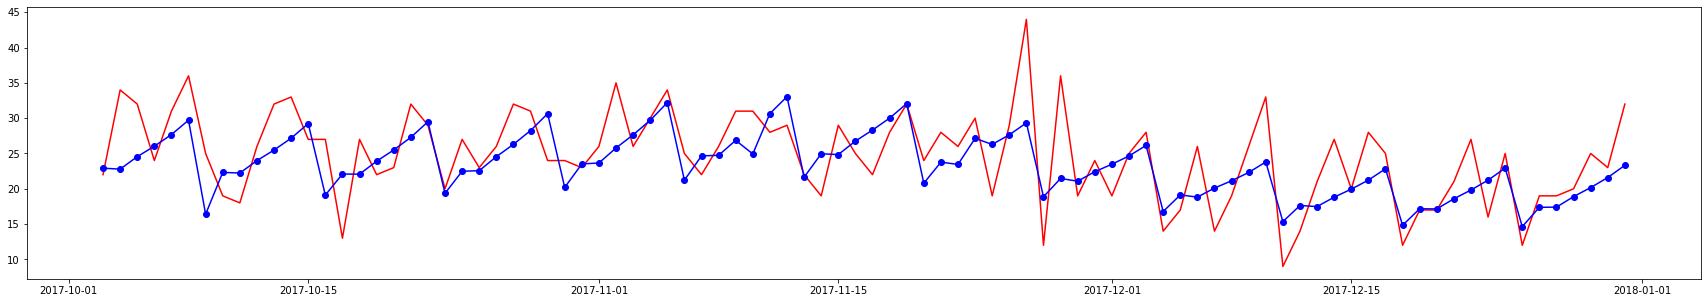

In [30]:
plt.figure(figsize=(30, 5))
plt.plot(test['ds'], test['y'], c='r', label='Test')
plt.plot(forecast['ds'], forecast['yhat'], c='blue', marker='o',label='Forecast')
plt.show()

In [31]:
y_true = test['y'].to_list()
y_true = np.array(y_true)
y_forecast = forecast['yhat'].to_list()
y_forecast = np.array(y_forecast)

smape = (np.absolute(y_true - y_forecast) / (np.absolute(y_true) + np.absolute(y_forecast))).mean() * 200
print('SMAPE  is:', smape)

SMAPE  is: 16.798935152308346


- Minor improvement or sometimes none through Log transform. However will include it in final model

- Lets look at cluster 2

In [32]:
# Random time series in cluster 2
no = random.randint(0,101)

index = clusters[1][no]

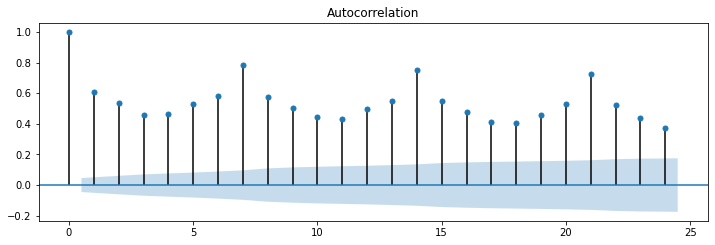

In [33]:
# Check for weekly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[index],lags=24,ax=ax)

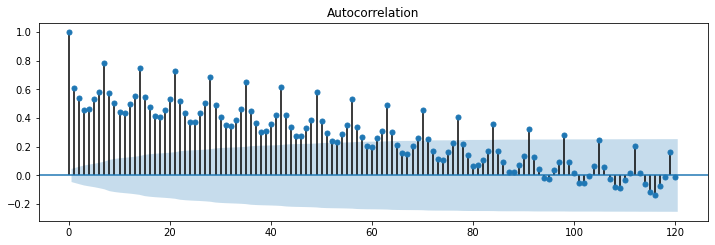

In [34]:
# Check for monthly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[index],lags=120,ax=ax)

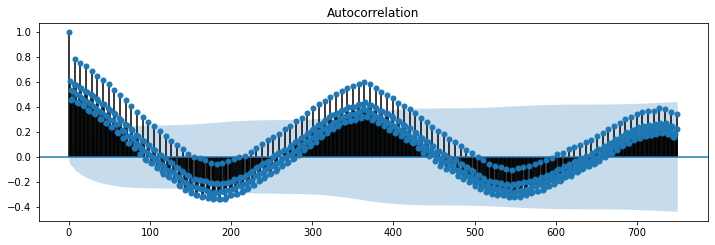

In [35]:
# Check for yearly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[index],lags=750,ax=ax)

Image Corresponding to Item: 35 And Store: 3


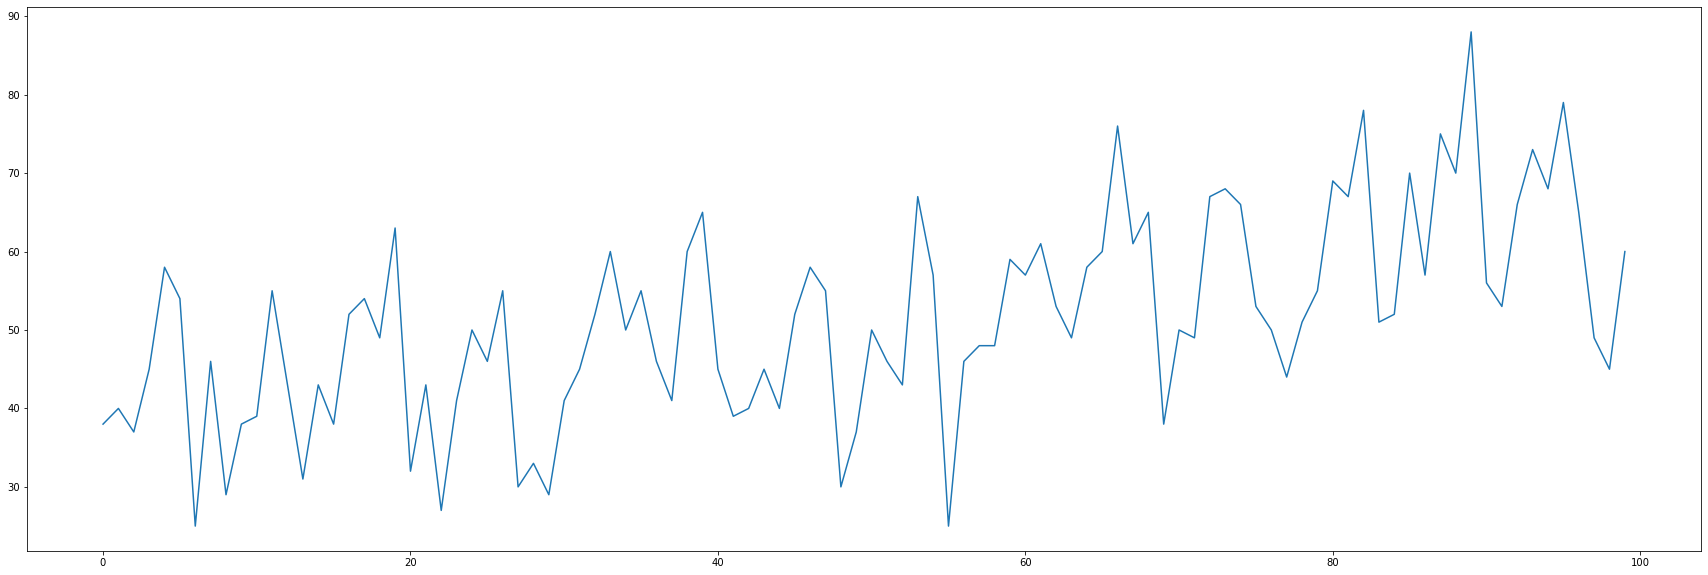

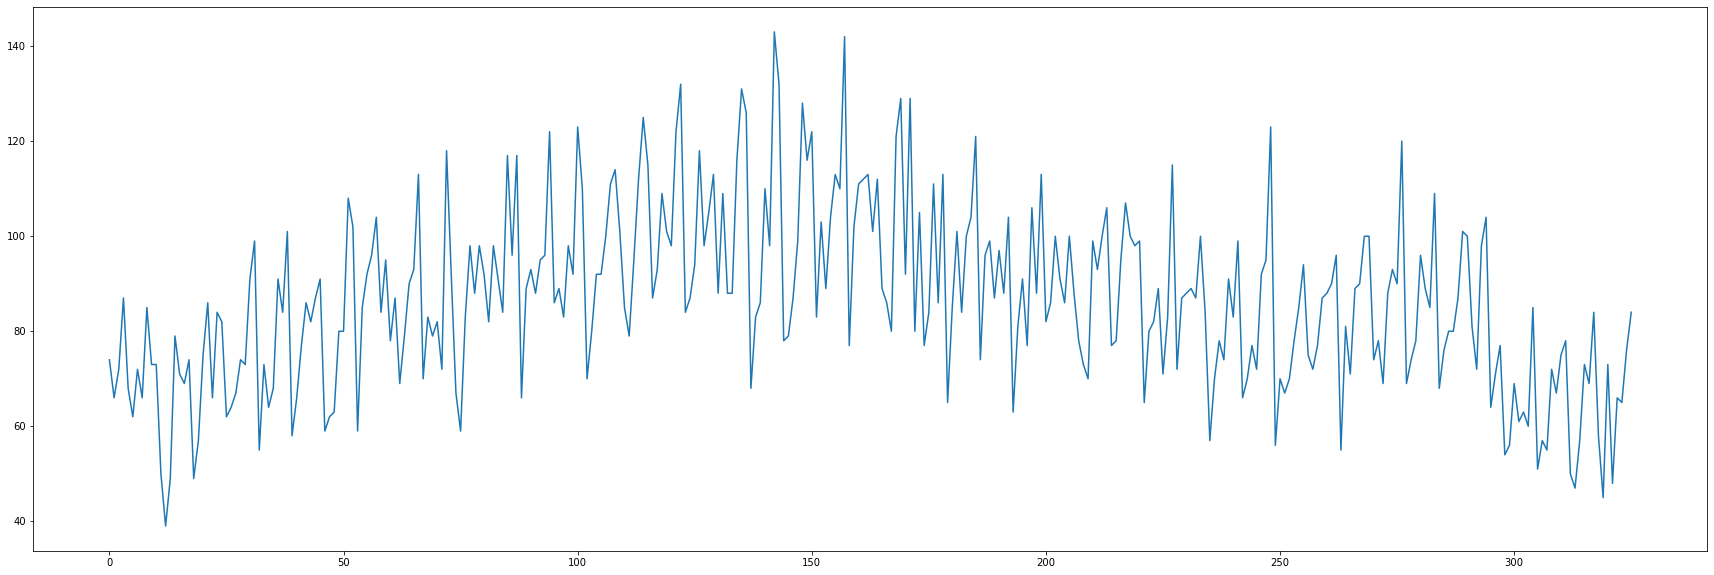

In [36]:
plt.figure(figsize=(30,10))
print("Image Corresponding to Item:",IndexSale_Series[index][1],"And Store:",IndexSale_Series[index][2])
plt.plot(Sales_series[index][:100])
plt.show()
plt.figure(figsize=(30,10))
plt.plot(Sales_series[index][1500:])
plt.show()

In [37]:
NonStationary = []

for saleID in clusters[1]:
    #print(Sales_series[saleID])
    result = adfuller(Sales_series[saleID])
    
    if result[1] > 0.05:
        
        NonStationary.append(saleID)
    else:
        pass      

print(NonStationary)

[12, 17, 28, 42, 58, 63, 66, 69, 99, 110, 113, 119, 121, 127, 131, 137, 151, 155, 160, 181, 199, 217, 235, 260, 264, 267, 282, 294, 313, 330, 351, 355, 379, 388, 413, 418, 451, 452, 461, 462, 467, 471, 473]


The patterns in both the clusters seems to be similar. We can use the same parameters for fitting

# Implement the model and find 3 months of results

In [38]:
train = pd.read_csv("../input/demand-forecasting-kernels-only/train.csv", parse_dates=['date'], index_col=['date'])
test = pd.read_csv("../input/demand-forecasting-kernels-only/test.csv",parse_dates=['date'],index_col=['date'])

results = test.reset_index()
results['sales'] = 0

stores = df['store'].unique()
items = df['item'].unique()

for store in stores :
    for item in items:
        
        to_train = train.loc[(train['store'] == store) & (train['item'] == item)].reset_index()
        to_train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        
        to_train['y'] = np.log1p(to_train['y'])
        
        model = Prophet(daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays = holidays, seasonality_mode='additive',holidays_prior_scale=0.5,)
        
        model.fit(to_train[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=len(test.index.unique()),include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == store) & (results['item'] == item),'sales'] = np.expm1(forecast['yhat']).values

In [39]:
results.drop(['date', 'store', 'item'], axis=1, inplace=True)
results.head()

id      sales
0   0  12.613109
1   1  14.576128
2   2  15.123459
3   3  15.615166
4   4  16.909606

In [40]:
results['sales'] = np.round(results['sales']).astype(int)

In [41]:
results.to_csv('submission.csv', index=False)